<a href="https://colab.research.google.com/github/tanderson11/covid_households/blob/main/SuperspreadingLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superspreading Laboratory

# Drive + Github Configuration

If running for the first time, uncomment the necessary lines to create a token and clone the repository.

You'll have to authenticate on google drive the first time and each time the runtime times out.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%mkdir /content/gdrive/My\ Drive/github
%cd /content/gdrive/My\ Drive/github

mkdir: cannot create directory ‘/content/gdrive/My Drive/github’: File exists
/content/gdrive/My Drive/github


In [3]:
# Request a token and then add it to the line below and then uncomment both lines
#!echo git_token=\"your_token_here\" > git_token.py
#from git_token import git_token

In [4]:
repo_owner="tanderson11"
repository="covid_households"

In [5]:
### UNCOMMENT THIS LINE TO CLONE FOR THE FIRST TIME
#!git clone https://{git_token}@github.com/{repo_owner}/{repository}

In [6]:
%cd covid_households/
!ls -al

# this will put your token in the right folder; comment this line out after use to avoid error message
#!mv ../git_token.py ./

from git_token import git_token

### UNCOMMENT THIS LINE TO PULL CHANGES
#!git pull

/content/gdrive/My Drive/github/covid_households
total 559435
-rw------- 1 root root   2510200 Apr 29 18:22 baseline_df.hdf
-rw------- 1 root root 331828072 Apr 28 14:54 comparison_df.hdf
-rw------- 1 root root      1335 Apr 20 16:17 constants.py
-rw------- 1 root root 237322952 Apr 27 15:33 df.hdf
drwx------ 3 root root      4096 Apr 29 20:21 experiments
-rw------- 1 root root      4144 Apr 20 16:17 forward_simulation.py
drwx------ 8 root root      4096 Apr 29 19:52 .git
-rw------- 1 root root      1450 Apr 21 14:00 .gitignore
-rw------- 1 root root        53 Apr 21 14:04 git_token.py
drwx------ 2 root root      4096 Apr 29 18:02 inf_var-hsar-seed_one-0.0importation-04-29-17:46
drwx------ 2 root root      4096 Apr 20 16:42 .ipynb_checkpoints
-rw------- 1 root root     56554 Apr 23 15:38 Lab.ipynb
-rw------- 1 root root       695 Apr 21 13:39 likelihood.py
-rw------- 1 root root    552092 Apr 23 18:20 ParameterInferenceLab.ipynb
-rw------- 1 root root     12430 Apr 29 20:00 population.

In [7]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   population.py
	modified:   utilities.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	baseline_df.hdf
	comparison_df.hdf
	df.hdf
	experiments/
	inf_var-hsar-seed_one-0.0importation-04-29-17:46/
	sus_var-hsar-seed_one-0.0importation-04-29-16:17/
	sus_var-hsar-seed_one-0.0importation-04-29-20:02/

no changes added to commit (use "git add" and/or "git commit -a")


# Initialization

In [8]:
# Initialization
import importlib
import vaccine
import population
import likelihood
import utilities
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import traits
import seaborn as sns
import datetime
import dill

# Reload modules

In [90]:
importlib.reload(vaccine)
importlib.reload(likelihood)
importlib.reload(population)
importlib.reload(utilities)
importlib.reload(traits)

<module 'traits' from '/content/gdrive/My Drive/github/covid_households/traits.py'>

# Experiments

## Trait configuration + baseline

In [9]:
# Gamma distributed traits

baseline_sus = traits.GammaTrait("susceptibility", mean=1.0, variance=0.0)
baseline_inf = traits.GammaTrait("infectivity", mean=1.0, variance=0.8)

#sus.plot()
#inf.plot()

In [10]:
# model parameters
#def __init__(name, state_length_dist=state_length_sampler, inf_dist=np.ones, sus_dist=np.ones, initial_seeding=utilities.seed_one_by_susceptibility, household_beta=0, importation_rate=0, duration=0, vaccine=None, vaccination_method=None)

baseline_hsar = 0.25
household_sizes = {6:25000}

duration = 90
cumulative_import_prob = 0.10
importation_rate = utilities.importation_rate_from_cumulative_prob(cumulative_import_prob, duration)

baseline_model = population.Model("baseline", inf_dist=baseline_inf, importation_rate=importation_rate, duration=duration, sus_dist=baseline_sus, household_beta=utilities.household_beta_from_hsar(baseline_hsar))
baseline_population = population.Population(baseline_model, household_sizes)

Model named baseline with:
	household_beta     = 0.043
	seeding            = <function seed_one_by_susceptibility at 0x7f274425b200>
	duration           = 90
	importation rate   = 0.001
	susceptibility     = Gamma distributed trait named susceptibility with mean 1.00 and variance 0.00
	infectiousness     = Gamma distributed trait named infectivity with mean 1.00 and variance 0.80



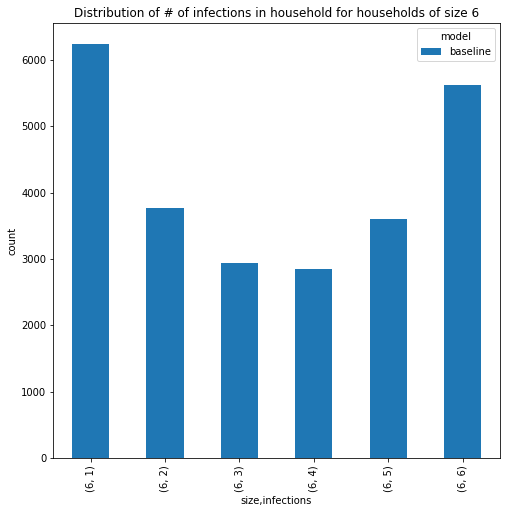

In [11]:
baseline_population.df["infections"] = baseline_population.simulate_population()
baseline_df = baseline_population.df
baseline_df["sus_var"] = baseline_sus.variance
baseline_df["inf_var"] = baseline_inf.variance
baseline_df["hsar"] = baseline_hsar
utilities.make_bar_chart(baseline_df)
print(baseline_model)

In [12]:
def make_comparison_df(sus_var, inf_var, hsar):
    household_sizes = {size:25000 for size in set(baseline_population.df["size"])} # 10000 at each unique size in the baseline population
    _sus_dist = traits.GammaTrait("susceptibility", mean=1.0, variance=sus_var)
    _inf_dist = traits.GammaTrait("susceptibility", mean=1.0, variance=inf_var)
    comparison_model = population.Model("comparison model", inf_dist=_inf_dist, sus_dist=_sus_dist, importation_rate=importation_rate, duration=duration, household_beta=utilities.household_beta_from_hsar(hsar))
    comparison_pop = population.Population(comparison_model, household_sizes)
    comparison_pop.df["infections"] = comparison_pop.simulate_population()
    return comparison_pop.df

In [13]:
sus_var_axis = np.linspace(0.0, 1.4, 15)
inf_var_axis = np.linspace(0.0, 1.4, 15)
hsar_axis = np.linspace(0.15, 0.35, 21)

axes_by_keys = {"sus_var": sus_var_axis, "inf_var":inf_var_axis, "hsar":hsar_axis}

#s_axis_strs = ["{:.2f}".format(s) for s in sus_var_axis]
#i_axis_strs = ["{:.2f}".format(i) for i in inf_var_axis]
#h_axis_strs = ["{:.2f}".format(h) for h in hsar_axis]

## Grids

In [14]:
def run_grid(key1, key2):
    arguments = {"sus_var":baseline_sus.variance, "inf_var":baseline_inf.variance, "hsar":baseline_hsar}

    comparison_dfs = []
    for y in axes_by_keys[key1]:
        for x in axes_by_keys[key2]:
            arguments[key1] = y
            arguments[key2] = x
            comparison = make_comparison_df(**arguments)

            for k,v in arguments.items():
                comparison[k] = np.float("{0:.2f}".format(v))

            comparison_dfs.append(comparison)

    full_comparison_df = pd.concat(comparison_dfs)
    return full_comparison_df

In [ ]:
# 

key1 = "sus_var"
key2 = "hsar"
name = "{}-{}-{}-{:.1f}importation".format(key1, key2, baseline_model.seeding.name, baseline_model.importation_rate)
date_str = datetime.datetime.now().strftime("%m-%d-%H:%M")
directory_name = "{}-{}".format(name, date_str)

full_comparison_df = run_grid(key1, key2)
print(full_comparison_df)

!mkdir ./experiments/{directory_name}
full_comparison_df.to_hdf('./experiments/{0}/comparison_df.hdf'.format(directory_name), key='full_comparison_df', mode='w')
baseline_df.to_hdf('./experiments/{0}/baseline_df.hdf'.format(directory_name), key='baseline_df', mode='w')
with open('./experiments/{0}/baseline_model.pickle'.format(directory_name), 'wb') as handle:
    pickle.dump(baseline_model, handle)

In [20]:
with open('./experiments/{0}/baseline_model.pickle'.format(directory_name), 'wb') as handle:
    dill.dump(baseline_model, handle)

In [ ]:
# SUS X HSAR
comparison_dfs = []

for sus_var in sus_var_axis:
    for hsar in hsar_axis:
        comparison = make_comparison_df(sus_var, inf.variance, hsar)
        comparison["sus_var"] = sus_var
        comparison["hsar"] = hsar
        comparison_dfs.append(comparison)
        #logl = likelihood.log_likelihood(["size", "infections"], baseline_df, comparison)

full_comparison_df = pd.concat(comparison_dfs)
full_comparison_df

In [ ]:
# INF X HSAR
comparison_dfs = []

for inf_var in inf_var_axis:
    for hsar in hsar_axis:
        comparison = make_comparison_df(sus.variance, inf_var, hsar)
        comparison["inf_var"] = inf_var
        comparison["hsar"] = hsar
        comparison_dfs.append(comparison)
        #logl = likelihood.log_likelihood(["size", "infections"], baseline_df, comparison)

full_comparison_df = pd.concat(comparison_dfs)
full_comparison_df

,size,model,infections,inf_var,hsar
0,6,comparison model,1,0.0,0.1
1,6,comparison model,1,0.0,0.1
2,6,comparison model,1,0.0,0.1
3,6,comparison model,1,0.0,0.1
4,6,comparison model,2,0.0,0.1
...,...,...,...,...,...
24995,6,comparison model,1,1.4,0.3
24996,6,comparison model,3,1.4,0.3
24997,6,comparison model,1,1.4,0.3
24998,6,comparison model,5,1.4,0.3


In [ ]:
# SUS X INF

X,Y = np.meshgrid(sus_var_axis, inf_var_axis)
f = lambda sus, inf: likelihood.log_likelihood(["size", "infections"], baseline_df, make_comparison_df(sus, inf, hsar))
Z = np.fromiter(map(f, X.ravel(), Y.ravel()), X.dtype).reshape(X.shape)

Model named baseline model with:
	household_beta     = 0.024
	seeding            = <function seed_one_by_susceptibility at 0x7f804f6ec710>
	duration           = 0
	importation rate   = 0.000
	susceptibility     = Gamma distributed trait named susceptibility with mean 1.00 and variance 0.80
	infectiousness     = Gamma distributed trait named infectivity with mean 1.00 and variance 0.00

baseline sizes: {6: 500}


Text(33.0, 0.5, 'guess for infectivity variance')

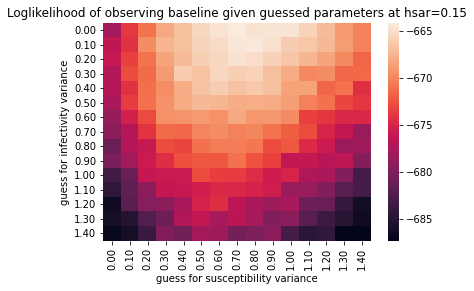

In [ ]:
print(baseline_model)
print("baseline sizes:", household_sizes)
sns.heatmap(Z, xticklabels=s_axis_strs, yticklabels=i_axis_strs)
plt.title("Loglikelihood of observing baseline given guessed parameters at hsar={}".format(hsar))
plt.xlabel("guess for susceptibility variance")
plt.ylabel("guess for infectivity variance")

Model named baseline model with:
	household_beta     = 0.024
	seeding            = <function seed_one_by_susceptibility at 0x7f804f6ec710>
	duration           = 0
	importation rate   = 0.000
	susceptibility     = Gamma distributed trait named susceptibility with mean 1.00 and variance 0.80
	infectiousness     = Gamma distributed trait named infectivity with mean 1.00 and variance 0.00

baseline sizes: {6: 500}


Text(33.0, 0.5, 'guess for hsar')

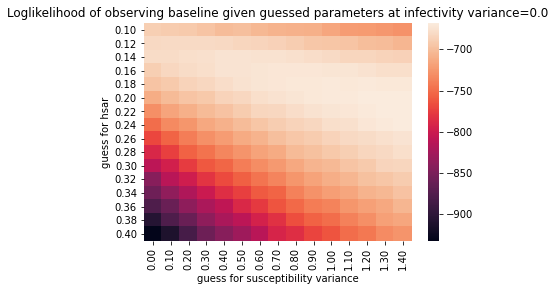

In [ ]:
# SUS X HSAR

X,Y = np.meshgrid(sus_var_axis, hsar_axis)
f = lambda sus, hsar: likelihood.log_likelihood(["size", "infections"], baseline_df, make_comparison_df(sus, inf.variance, hsar))
Z = np.fromiter(map(f, X.ravel(), Y.ravel()), X.dtype).reshape(X.shape)

print(baseline_model)
print("baseline sizes:", household_sizes)
sns.heatmap(Z, xticklabels=s_axis_strs, yticklabels=h_axis_strs)
plt.title("Loglikelihood of observing baseline given guessed parameters at infectivity variance={}".format(inf.variance))
plt.xlabel("guess for susceptibility variance")
plt.ylabel("guess for hsar")

In [ ]:
# HSAR X INF

X,Y = np.meshgrid(hsar_axis, inf_var_axis)
f = lambda hsar, inf: likelihood.log_likelihood(["size", "infections"], baseline_df, make_comparison_df(sus.mean, inf, hsar))
Z = np.fromiter(map(f, X.ravel(), Y.ravel()), X.dtype).reshape(X.shape)

In [ ]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


In [ ]:
#%matplotlib widget
print(baseline_model)
print("baseline sizes:", household_sizes)
sns.heatmap(Z, xticklabels=h_axis_strs, yticklabels=i_axis_strs)
plt.title("Loglikelihood of observing baseline given guessed parameters at susceptibility variance={}".format(sus.variance))
plt.ylabel("guess for infectivity variance")
plt.xlabel("guess for hsar")

ModuleNotFoundError: ignored

# Making a git commit from changes to python backend

To save this notebook use File > Save a copy in Github

In [21]:
!git add -A
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   baseline_df.hdf
	new file:   comparison_df.hdf
	new file:   df.hdf
	new file:   experiments/sus_var-hsar-seed_one-0.0importation-04-29-20:25/baseline_df.hdf
	new file:   experiments/sus_var-hsar-seed_one-0.0importation-04-29-20:25/baseline_model.pickle
	new file:   experiments/sus_var-hsar-seed_one-0.0importation-04-29-20:25/comparison_df.hdf
	new file:   inf_var-hsar-seed_one-0.0importation-04-29-17:46/baseline_df.hdf
	new file:   inf_var-hsar-seed_one-0.0importation-04-29-17:46/baseline_model.pickle
	new file:   inf_var-hsar-seed_one-0.0importation-04-29-17:46/comparison_df.hdf
	modified:   population.py
	new file:   sus_var-hsar-seed_one-0.0importation-04-29-16:17/baseline_df.hdf
	new file:   sus_var-hsar-seed_one-0.0importation-04-29-16:17/comparison_df.hdf
	new file:   sus_var-hsar-seed_one-0.0importation-04-29-20:02/baseline_df.hdf
	mo

In [ ]:
!git config --global user.email ""
!git config --global user.email "Thayer"

In [ ]:
message = input("Commit message? ")

!git commit -m "{message}"

Commit message? Fixed error with graphing. Better handling of traits
[main b13afde] Fixed error with graphing. Better handling of traits
 4 files changed, 19 insertions(+), 11 deletions(-)


# Pushing upstream

In [ ]:
!git remote set-url origin https://{git_token}@github.com/{repo_owner}/{repository}

In [ ]:
!git pull

Already up to date.


In [ ]:
#from git_token import git_token
#!git remote set-url origin https://{git_token}@github.com/{username}/{repository}

!git push

Counting objects: 12, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 1.99 KiB | 340.00 KiB/s, done.
Total 12 (delta 10), reused 0 (delta 0)
remote: Resolving deltas: 100% (10/10), completed with 5 local objects.
To https://github.com/tanderson11/covid_households
   ee3ae67..b13afde  main -> main
